In [1]:
import os # For finding source files
from pathlib import Path

import pandas as pd # For data handling

In [2]:
DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path's parent
CSVFilePath = str(DirPpath.absolute()) + "\CleanedData.csv"  

print("Current Location of the Data file is :", CSVFilePath)

PledgeDf = pd.read_csv(CSVFilePath, index_col=0) # Creating a dataframe from the content of the csv file # Args: index_col = 0, first column of the csv contains the indexes

# Inspecting the first rows of the dataframe
PledgeDf.head()


Current Location of the Data file is : c:\Users\ecaudron001\Documents\GitHub\semic_pledges\CleanedData.csv


,Topic,Pledge
0,1,Actually we as an association are still pretty...
1,1,EFFAT welcomes the Commission Proposal for a R...
2,1,HOTREC calls for a level playing field and fai...
3,1,Estonia sees the need to synchronize and harmo...
4,1,Sphere Travel Club contributes to a flourishin...


# NER with spacy

## Small preprocessing

In [3]:
import string
import re
import contractions

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

def first_clean(text):
    return " ".join(text.split())

def RemoveURL(text):
    """Remove URLs from a sample string"""
    text = re.sub(r"https:\s?\S+", "", text)
    text = re.sub(r"http\S+", "", text) 
    #text = text.replace("-", " ")
    #text = text.replace("/", " ")
    return re.sub(r'[^\x00-\x7f]',r'',  text) # Remove non-ASCII

PledgeDf["PreProcessedText"] = PledgeDf["Pledge"].apply(lambda x: RemoveURL(first_clean(x)))


## Sentence tokenization

In [4]:
import spacy
from spacy import displacy

In [5]:
nlp = spacy.load("en_core_web_sm")

SentTokens = [[sent.text for sent in nlp(doc).sents] for doc in PledgeDf["PreProcessedText"]]

## Filter on Date

In [17]:
def NERDates(doc, datelim):

    # 1° NER Dates
    datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
    dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE" and ((re.search(r"[12][0-9]{3}", ent.text) and int(re.findall(r"[12][0-9]{3}", ent.text)[0]) > datelim) or (re.search(r"^(-within|up to)", ent.text)))) #Limit ourself to expression with years > 2022
    filteredDates = set(date for date in dates if not datesPattern.match(date))

    return filteredDates

def ExceptionDates(doc, filteredDates, datelim):

    # 2° Exceptions 1 --> Dates intervals using regex
    exceptions = re.findall(r"[12][0-9]{3}\-[12][0-9]{3}|[12][0-9]{3}\/[12][0-9]{3}", doc.text)

    for exception in exceptions:
        if int(re.findall(r"[12][0-9]{3}$", exception)[0]) > datelim:
            filteredDates.add(exception)

    # 3° Exceptions 2 --> Specific structures using regex
    exceptions = re.findall(r"(by 2025 data|up to 2027 are:|Target: 2023|the project - 2023|end of 2023 NBTC|a framework Q2 2023)", doc.text)
    #print(exceptions)
    for exception in exceptions:
        if int(re.findall(r"[12][0-9]{3}", exception)[0]) > datelim:
            filteredDates.add(exception)

    

In [ ]:
# For each sentence look for dates > 2022 and in numerical format

MultDatesSent = []
DatesSent = []
DatesPledge = []

for Pledge in SentTokens:

    datesPresent = 0

    for sent in Pledge:

        doc = nlp(sent)

        filteredDates = NERDates(doc, 2022)
        ExceptionDates(doc, filteredDates, 2022)
        

        # Resultats
        if filteredDates != set():
            DatesSent.append(sent)
            print(filteredDates)
            datesPresent = 1

            if len(filteredDates)> 1:
                MultDatesSent.append(sent)
                print(sent)
    
    #print(datesPresent)
    DatesPledge.append(datesPresent)



In [25]:
# Outputing sentence with more than 1 date for analysis

len(MultDatesSent)

MultDatesDf = pd.DataFrame(MultDatesSent, columns=["Sentence"])
MultDatesDf.to_excel("NER3.xlsx")

In [ ]:
# Dependency analysis

from spacy import displacy

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")

    doc = nlp(sent)

    print(f"{'Node (from)-->':<15} {'Relation':^10} {'-->Node (to)':>15}\n")
    for token in doc:
        print("{:<15} {:^10} {:>15}".format(str(token.head.text), str(token.dep_), str(token.text)))
    displacy.render(doc, style='dep')


In [ ]:
# Noun and verb phrases

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")

    doc = nlp(sent)

    for chunk in doc.noun_chunks:
        print(chunk)

    print("----------------------------------------")

In [ ]:
import textacy

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")

    #patterns = [{"POS": "AUX"}, {"POS": "VERB"}]
    patterns = [{'POS': 'VERB', 'OP': '?'},
           {'POS': 'ADV', 'OP': '*'},
           {'POS': 'VERB', 'OP': '+'}]
    about_talk_doc = textacy.make_spacy_doc(
    sent, lang="en_core_web_sm")

    verb_phrase = textacy.extract.token_matches(about_talk_doc, patterns=patterns)

    for chunk in verb_phrase:
        print(chunk.text)

    print("----------------------------------------")

In [ ]:
import stanza

nlp2 = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')

In [70]:
stanza.install_corenlp()

2023-04-21 13:56:15 WARNING: Directory C:\Users\ecaudron001\stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [71]:
import re

import nltk


def get_verb_phrases(t):
    verb_phrases = []
    num_children = len(t)
    num_VP = sum(1 if t[i].label() == "VP" else 0 for i in range(0, num_children))

    if t.label() != "VP":
        for i in range(0, num_children):
            if t[i].height() > 2:
                verb_phrases.extend(get_verb_phrases(t[i]))
    elif t.label() == "VP" and num_VP > 1:
        for i in range(0, num_children):
            if t[i].label() == "VP":
                if t[i].height() > 2:
                    verb_phrases.extend(get_verb_phrases(t[i]))
    else:
        verb_phrases.append(' '.join(t.leaves()))

    return verb_phrases


def get_pos(t):
    vp_pos = []
    sub_conj_pos = []
    num_children = len(t)
    children = [t[i].label() for i in range(0, num_children)]

    flag = re.search(r"(S|SBAR|SBARQ|SINV|SQ)", ' '.join(children))

    if "VP" in children and not flag:
        for i in range(0, num_children):
            if t[i].label() == "VP":
                vp_pos.append(t[i].treeposition())
    elif not "VP" in children and not flag:
        for i in range(0, num_children):
            if t[i].height() > 2:
                temp1, temp2 = get_pos(t[i])
                vp_pos.extend(temp1)
                sub_conj_pos.extend(temp2)
    # comment this "else" part, if want to include subordinating conjunctions
    else:
        for i in range(0, num_children):
            if t[i].label() in ["S", "SBAR", "SBARQ", "SINV", "SQ"]:
                temp1, temp2 = get_pos(t[i])
                vp_pos.extend(temp1)
                sub_conj_pos.extend(temp2)
            else:
                sub_conj_pos.append(t[i].treeposition())

    return (vp_pos, sub_conj_pos)


def print_clauses(parse_str):
    sent_tree = nltk.tree.ParentedTree.fromstring(parse_str)
    clause_level_list = ["S", "SBAR", "SBARQ", "SINV", "SQ"]
    clause_list = []
    sub_trees = []
    # sent_tree.pretty_print()

    # break the tree into subtrees of clauses using
    # clause levels "S","SBAR","SBARQ","SINV","SQ"
    for sub_tree in reversed(list(sent_tree.subtrees())):
        if sub_tree.label() in clause_level_list:
            if sub_tree.parent().label() in clause_level_list:
                continue

            if (len(sub_tree) == 1 and sub_tree.label() == "S" and sub_tree[0].label() == "VP"
                    and not sub_tree.parent().label() in clause_level_list):
                continue

            sub_trees.append(sub_tree)
            del sent_tree[sub_tree.treeposition()]

    # for each clause level subtree, extract relevant simple sentence
    for t in sub_trees:
        # get verb phrases from the new modified tree
        verb_phrases = get_verb_phrases(t)

        # get tree without verb phrases (mainly subject)
        # remove subordinating conjunctions
        vp_pos, sub_conj_pos = get_pos(t)
        for i in reversed(vp_pos):
            del t[i]
        for i in reversed(sub_conj_pos):
            del t[i]

        subject_phrase = ' '.join(t.leaves())

        # update the clause_list
        for i in verb_phrases:
            clause_list.append(subject_phrase + " " + i)

    print(clause_list)
    return clause_list

In [72]:
from stanza.server import CoreNLPClient

text = sent

with CoreNLPClient(
        annotators=['tokenize', 'pos', 'lemma', 'parse', 'depparse'],
        output_format="json",
        timeout=30000,
        memory='16G') as client:
    output = client.annotate(text)
    # print(output.sentence[0])
    parse_tree = output['sentences'][0]['parse']
    parse_tree = ' '.join(parse_tree.split())

print_clauses(parse_str=parse_tree)

2023-04-21 13:56:30 INFO: Writing properties to tmp file: corenlp_server-8063d420f9004b43.props


PermanentlyFailedException: Error: unable to start the CoreNLP server on port 9000 (possibly something is already running there)

In [66]:
from nltk import Tree

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")
    doc = nlp2(sent)

    for sentence in doc.sentences:
        parse_str = str(sentence.constituency)
        
        t = Tree.fromstring(parse_str)
        #print t

        subtexts = []
        for subtree in t.subtrees():
            if subtree.label()=="S" or subtree.label()=="SBAR":
                #print subtree.leaves()
                subtexts.append(' '.join(subtree.leaves()))
        #print subtexts

        presubtexts = subtexts[:]       # ADDED IN EDIT for leftover check

        for i in reversed(range(len(subtexts)-1)):
            subtexts[i] = subtexts[i][0:subtexts[i].index(subtexts[i+1])]

        for text in subtexts:
            print(text)

    print("----------------------------------------")

    # ADDED IN EDIT - Not sure for generalized cases
    # leftover = presubtexts[0][presubtexts[0].index(presubtexts[1])+len(presubtexts[1]):]
    # print(leftover)

EFFAT will - in 2023-2024, follow the legislative procedure for the Regulation through European Parliament and Council of Ministers - during this legislative procedure, regularly keep its national member organisations updated about the legislation in the making, by reporting at least 2 times per year on the progress made and agree on measures to be taken by EFFAT and national affiliates - once the Regulation is finally adopted, ask national member organisations to monitor the transposition of the Regulation in their countries and to push for its proper implementation, and to report at least 2 times per year about the actions taken and the progress made - follow the work of the Single Digital Entry Points Coordination Group composed of Member States' national coordinators - continue to address the issue of short-term accommodation rental services in the Sectoral Social Dialogue Committee Horeca, by putting it on the agenda of the 2 Working Group and 1 Plenary meetings per year, and to u

ValueError: substring not found

In [62]:
# stanza.install_corenlp()

from stanza.server import CoreNLPClient

text = "Joe realized that the train was late while he waited at the train station"

with CoreNLPClient(
        annotators=['tokenize', 'pos', 'lemma', 'parse', 'depparse'],
        output_format="json",
        timeout=30000,
        memory='16G') as client:
    output = client.annotate(text)
    # print(output.sentence[0])
    parse_tree = output['sentences'][0]['parse']
    parse_tree = ' '.join(parse_tree.split())

2023-04-21 13:43:01 INFO: Writing properties to tmp file: corenlp_server-0c1ac8c3895c4e6e.props


FileNotFoundError: Please install CoreNLP by running `stanza.install_corenlp()`. If you have installed it, please define $CORENLP_HOME to be location of your CoreNLP distribution or pass in a classpath parameter.  $CORENLP_HOME=None

In [9]:
from datetime import datetime

datetime_str = '09/19/22 13:55:26'

datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

print(type(datetime_object))
print(datetime_object)  # printed in default format

<class 'datetime.datetime'>
2022-09-19 13:55:26


In [15]:
from datetime import datetime

date = datetime.strptime("February 2023", '%B %Y')
print(date)

2023-02-01 00:00:00


In [19]:
len(DatesSent)

455

In [20]:
DatesPledge.count(0)

66

In [90]:
PledgeDf.to_excel("NER_2.xlsx")

<Axes: xlabel='Date'>

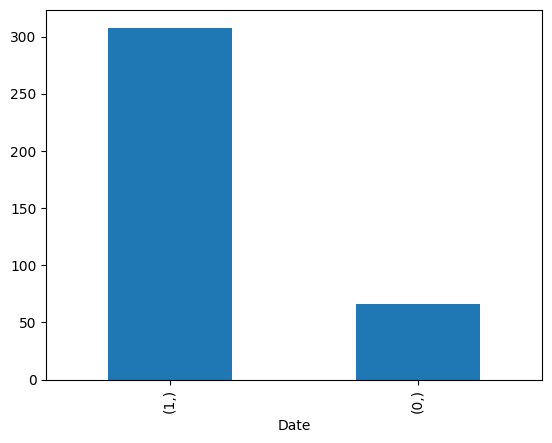

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame(DatesPledge, columns=["Date"])

data.value_counts().plot(kind="bar")


In [17]:
nlp = spacy.load("en_core_web_sm")

sentence = PledgeDf["Pledge"].iloc[285]

doc = nlp(sentence)

displacy.render(doc, style = "ent", jupyter = True)

In [42]:
from nltk.tokenize import sent_tokenize, TabTokenizer

DatesSentDf = pd.DataFrame()
DatesSent = []
Topic = []

for i in range(272): 
    sentence = PledgeDf["Pledge"].iloc[i]

    doc = nlp(sentence)

    datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
    dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE")
    filteredDates = set(date for date in dates if not datesPattern.match(date))

    for sent in doc.sents:

        if any(date in sent.text for date in filteredDates): 

            #print(sent)
            Topic.append(PledgeDf["Topic"].iloc[i])
            DatesSent.append(sent.text)


            # if any(ele in sent.text for ele in resultWords): 
            #     print(sent)





In [31]:
len(DatesSent)

478

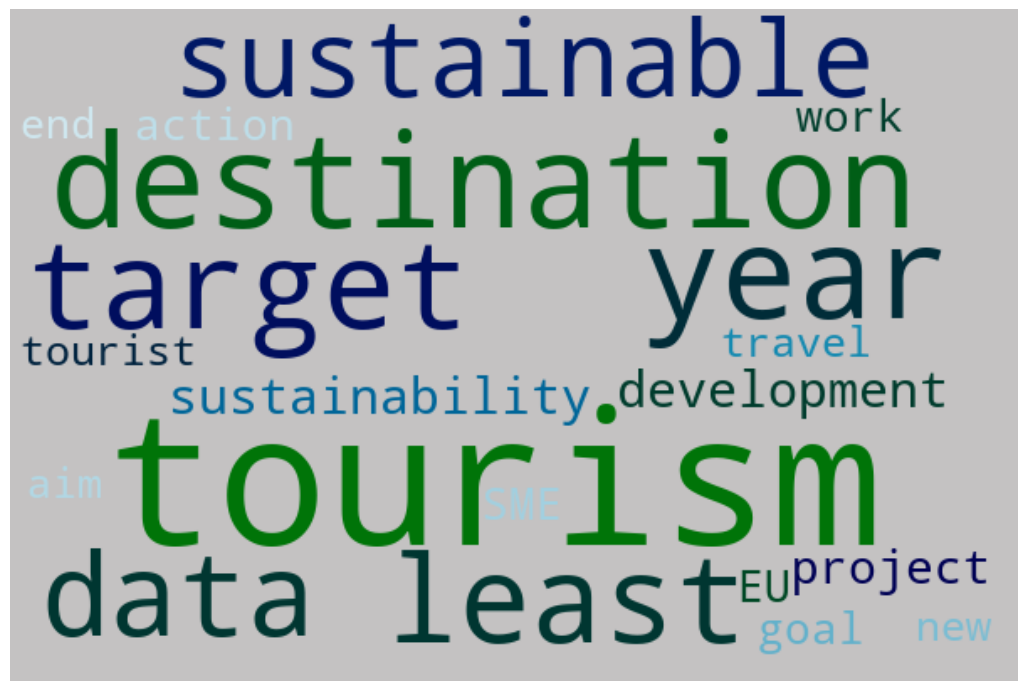

In [43]:
# Most frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

def wordcloud(data):

    cloud=WordCloud(colormap="ocean_r",width=600,height=400, background_color="#c4c2c2", max_words=20, stopwords=stopwords.words("english")).generate(data["PreProcessedText"].str.cat(sep=' ')) # Setting color for the map, background + defining dimensions
    fig=plt.figure(figsize=(13,18)) # Size of the figure
    plt.axis("off") # Removing the axis
    plt.imshow(cloud,interpolation='bilinear')
    plt.show()

DatesSentDf["PreProcessedText"] = DatesSent 
DatesSentDf["Topic"] = Topic
wordcloud(DatesSentDf)


In [45]:
resultWords = ["As a target for", "by", "prepare", "aim", "action", "results", "result", "target", "targets"]

ResultsSent = []
Dates = []
Topic = []
ResultsDf = pd.DataFrame()

DatesSentDf = PledgeDf[PledgeDf["Dates ?"] == 1]

for sent, topic, date in zip(DatesSentDf["PreProcessedText"], DatesSentDf["Topic"], DatesSentDf["Date"]):

    if any(ele in sent for ele in resultWords): 
        
        doc = nlp(sent)

        datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
        dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE")
        filteredDates = set(date for date in dates if not datesPattern.match(date))

        for date in filteredDates:

            Dates.append(date)
            ResultsSent.append(sent)
            Topic.append(topic)

ResultsDf["Sentence"] = ResultsSent
ResultsDf["Dates"] = Dates
ResultsDf["Topic"] =Topic


In [46]:
ResultsDf

,Sentence,Dates,Topic
0,Our target for 2025 is to achieve that guideli...,2025,1
1,The actions described above shall contribute t...,2025,1
2,The actions described above shall contribute t...,at least 2 years,1
3,Our target for 2025 is to have at least 15 pro...,2025,1
4,"Furthermore, many holiday properties stand emp...",the year,1
...,...,...,...
275,Our organization commits to:\r\n\r\nExternal:\...,2225,16
276,"Keep updated on the ""Visit Värmland’s Toolbox ...",three months,16
277,Traveler ID is already used by many airlines a...,2030,17
278,We expect to have this system implemented by 2...,2025,18


In [47]:
ResultsDf.to_excel("NER.xlsx")

# NER with ctparse

In [13]:
from ctparse import ctparse
from datetime import datetime

In [20]:
ts = datetime(2023, 4,17,9,42)
ctparse("the year", ts = ts)

CTParse(2023-12-31 X:X (X/X), (119, 'ruleEOY'), -977.9325646617849)